In [15]:
%matplotlib inline
from nilearn import datasets, signal
from nilearn.maskers import NiftiMasker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]
confound_filename = dataset.confounds[0]

In [2]:
# Extract the voxel-wise time series from the BOLD file, without cleaning it.
brain_masker = NiftiMasker(
    smoothing_fwhm=0,
    detrend=False,
    standardize=False,
    low_pass=None,
    high_pass=None,
    t_r=2,
    memory='nilearn_cache',
    memory_level=1,
    verbose=0,
)
brain_time_series = brain_masker.fit_transform(
    func_filename,
    confounds=None,
)

In [3]:
# Load the confounds and flag good volumes
confounds_df = pd.read_table(confound_filename)
confounds = confounds_df[["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]].to_numpy()
fd = confounds_df["framewise_displacement"].to_numpy()
good_volumes = np.where(fd <= 0.2)[0]

In [4]:
print(brain_time_series.shape)
print(confounds.shape)
print(good_volumes.shape)

(168, 32504)
(168, 6)
(131,)


In [12]:
# Zero-pad all of the relevant arrays
n_pad = 100

zeropad = np.zeros((n_pad, brain_time_series.shape[1]))
brain_time_series_padded = np.vstack((zeropad, brain_time_series, zeropad))
zeropad = np.zeros((n_pad, confounds.shape[1]))
confounds_padded = np.vstack((zeropad, confounds, zeropad))
zeropad = np.zeros(n_pad)
fd_padded = np.hstack((zeropad, fd, zeropad))
good_volumes_padded = np.where(fd_padded <= 0.2)[0]

In [13]:
print(brain_time_series_padded.shape)
print(confounds_padded.shape)
print(fd_padded.shape)
print(good_volumes_padded.shape)

(368, 32504)
(368, 6)
(368,)
(331,)


In [18]:
# Denoise both the original and padded versions of the data
unpadded_denoised = signal.clean(
    brain_time_series,
    detrend=False,
    sample_mask=good_volumes,
    confounds=confounds,
    standardize_confounds=True,
    filter=None,
    t_r=2,
)

padded_denoised = signal.clean(
    brain_time_series_padded,
    detrend=False,
    sample_mask=good_volumes_padded,
    confounds=confounds_padded,
    standardize_confounds=True,
    filter=None,
    t_r=2,
)
padded_denoised_cropped = padded_denoised[n_pad:-n_pad, :]
assert unpadded_denoised.shape == padded_denoised_cropped.shape

[[1.         0.02023677]
 [0.02023677 1.        ]]


<ipython-input-23-2f9afd78df9b>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


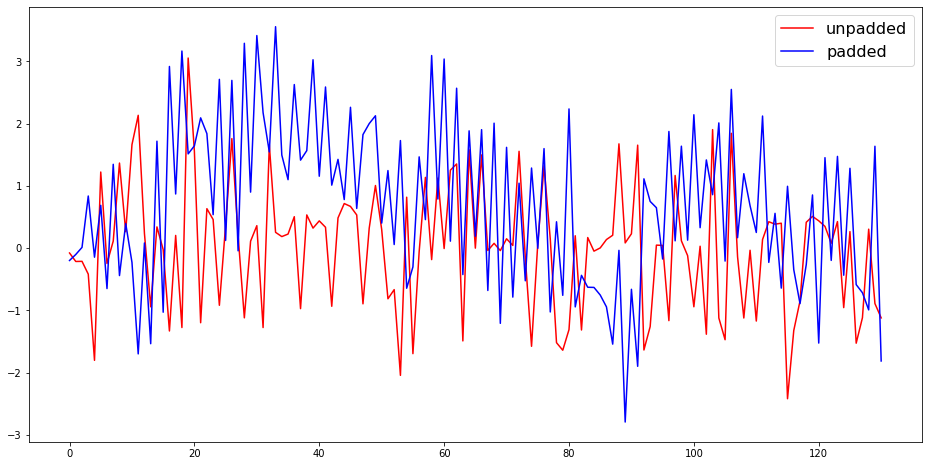

In [23]:
# Compare the two with a single voxel's time series
vox_idx = 10000
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(unpadded_denoised[:, vox_idx], color="red", label="unpadded")
ax.plot(padded_denoised_cropped[:, vox_idx], color="blue", label="padded")
ax.legend(fontsize=16)
fig.show()
print(np.corrcoef((unpadded_denoised[:, vox_idx], padded_denoised_cropped[:, vox_idx])))